<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/Development/CIFAR_100_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

--2021-02-26 19:58:53--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  50.0MB/s    in 3.6s    

2021-02-26 19:58:57 (44.8 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]



In [2]:
!mkdir cifar-100
!tar -xf cifar-100-python.tar.gz -C ./cifar-100
!rm -rf cifar-100-python.tar.gz

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
from pickle import load
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [4]:
workdir = os.curdir
datadir = os.path.join(workdir, 'cifar-100', 'cifar-100-python')
train_data_file = os.path.join(datadir, 'train')
test_data_file = os.path.join(datadir, 'test')
meta_data_file = os.path.join(datadir, 'meta')

In [47]:
def extract_data(filename):
  with open(filename, 'rb') as fo:
    dataset = load(fo, encoding='bytes')
  dataset[b'data'] = np.reshape(dataset[b'data'], (len(dataset[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)/255.0
  lb_bin = LabelBinarizer().fit(np.array(dataset[b'fine_labels']))
  dataset[b'fine_labels'] = lb_bin.transform(dataset[b'fine_labels'])
  dataset = (dataset[b'data'],
             dataset[b'fine_labels'])
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  return dataset

def transform_data(dataset):
  dataset = dataset.shuffle(100).repeat().batch(64)
  return dataset

def load_meta(filename):
  with open(filename, 'rb') as fo:
    metadata = load(fo, encoding='bytes')
  meta_mapping = dict()
  meta_mapping['coarse_labels'] = {i:metadata[b'coarse_label_names'][i].decode('utf-8')
                                  for i in range(len(metadata[b'coarse_label_names']))}

  meta_mapping['fine_labels'] = {i:metadata[b'fine_label_names'][i].decode('utf-8')
                                  for i in range(len(metadata[b'fine_label_names']))}
  return meta_mapping

In [48]:
train_dataset = extract_data(train_data_file)
train_dataset = transform_data(train_dataset)

test_dataset = extract_data(test_data_file)
test_dataset = transform_data(test_dataset)

metadata = load_meta(meta_data_file)

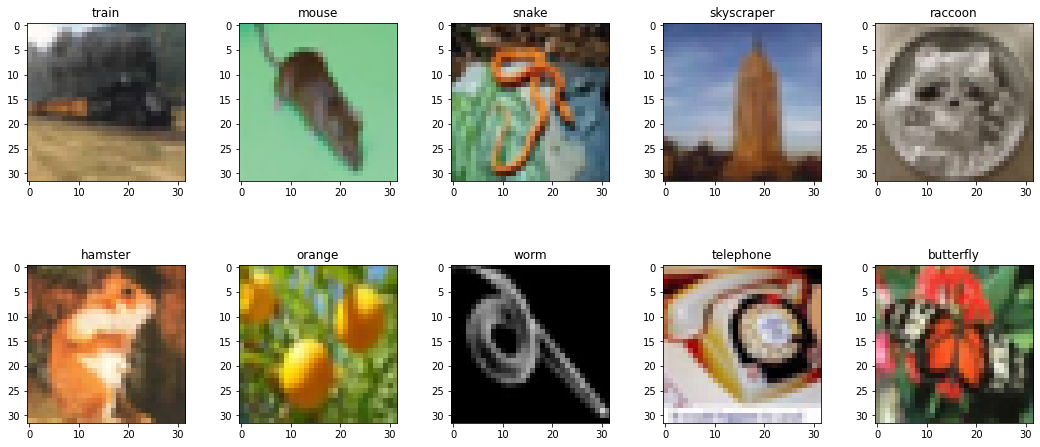

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,7))
fig.tight_layout(pad=2)
imgs, fine, corse = 0, 0, 0
for i in train_dataset.take(1):
  imgs, fine = i
  #fine, corse = labels  
for i in range(10):
  samp = imgs[i].numpy()
  fn = metadata['fine_labels'][np.argmax(fine[i].numpy())]
  #cr = metadata['coarse_labels'][corse[i].numpy()]
  ax[int(i/5)][i%5].imshow(samp)
  ax[int(i/5)][i%5].set_title(f"{fn}")

In [50]:
def Residual_Layer(input_layer, filters, layer_len, reg, dr):
  #print(filters, layer_len)
  # Main Branch
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same', kernel_regularizer=reg)(input_layer)
  x = tf.keras.layers.BatchNormalization()(x)

  for i in range(1, layer_len):
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same', kernel_regularizer=reg)(x)
    x = tf.keras.layers.BatchNormalization()(x)

  # Skip Branch
  x1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=reg)(input_layer)
  x1 = tf.keras.layers.BatchNormalization()(x1)

  # join the 2 branches
  x = tf.keras.layers.add([x, x1])
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
  x = tf.keras.layers.Dropout(dr)(x)
  return x

In [51]:
def define_model(main_layer, reg=None, dr=0.0, dr2=0.0):
  inputs = tf.keras.Input(shape=input_shape)
  
  x = tf.keras.layers.Conv2D(32, 5, strides=1, padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

  for filters, layer_len in main_layer:
    x = Residual_Layer(x, filters, layer_len, reg, dr)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(dr2)(x)
  x = tf.keras.layers.Dense(128, kernel_regularizer=reg)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(dr2)(x)
  x = tf.keras.layers.Dense(128, kernel_regularizer=reg)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(dr2)(x)
  x = tf.keras.layers.Dense(128, kernel_regularizer=reg)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(dr2)(x)

  outputs = tf.keras.layers.Dense(100, activation='softmax')(x)
  
  model = tf.keras.Model(inputs, outputs)
  return model

In [52]:
input_shape = (32, 32, 3)

In [55]:
reg = tf.keras.regularizers.L2(l2=0.001)
main_layer = [(128,3), (256,3), (256,3), (512, 4)]
dr = 0.3
dr2 = 0.4
model = define_model(main_layer, reg, dr, dr2)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 32, 32, 32)   2432        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 32, 32, 32)   128         conv2d_126[0][0]                 
__________________________________________________________________________________________________
activation_116 (Activation)     (None, 32, 32, 32)   0           batch_normalization_144[0][0]    
____________________________________________________________________________________________

In [56]:
erly_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True,
)

model_monit = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(os.curdir,'Checkpoint.model'), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min'
)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

#exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.01)
val_loss, loss, accuracy, val_accuracy = list(), list(), list(), list()

In [57]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.1)
history = model.fit(train_dataset.take(48000), steps_per_epoch=1000, epochs=50, validation_data=train_dataset.skip(2000), validation_steps=10
                    ,callbacks=[lr_scheduler, model_monit, erly_stop])
val_loss = val_loss + history.history['val_loss']
val_accuracy = val_accuracy + history.history['val_accuracy']
loss = loss +  history.history['loss']
accuracy = accuracy + history.history['accuracy']

Epoch 1/50
1000/1000 [==============================] - 42s 39ms/step - loss: 64.4380 - accuracy: 0.0096 - val_loss: 4.6397 - val_accuracy: 0.0109
Epoch 2/50
1000/1000 [==============================] - 37s 37ms/step - loss: 4.6347 - accuracy: 0.0105 - val_loss: 4.6466 - val_accuracy: 0.0078
Epoch 3/50
1000/1000 [==============================] - 37s 37ms/step - loss: 4.6388 - accuracy: 0.0105 - val_loss: 4.6510 - val_accuracy: 0.0109
Epoch 4/50
1000/1000 [==============================] - 37s 37ms/step - loss: 4.6404 - accuracy: 0.0101 - val_loss: 4.6358 - val_accuracy: 0.0078
Epoch 5/50
1000/1000 [==============================] - 37s 37ms/step - loss: 4.6401 - accuracy: 0.0091 - val_loss: 4.6450 - val_accuracy: 0.0109
Epoch 6/50
1000/1000 [==============================] - 37s 37ms/step - loss: 4.6404 - accuracy: 0.0096 - val_loss: 4.6351 - val_accuracy: 0.0078
Epoch 7/50
1000/1000 [==============================] - 37s 37ms/step - loss: 4.6402 - accuracy: 0.0110 - val_loss: 4.6449 

KeyboardInterrupt: ignored